In [83]:
import requests
import pickle
import pandas as pd
import numpy as np
from numpy import random
import itertools
import matplotlib.pyplot as plt
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
sns.set_style('darkgrid')
from wordcloud import WordCloud
from ipywidgets import interact, interact_manual, widgets

from surprise import SVD, Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import NormalPredictor
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import BaselineOnly
from surprise import CoClustering

# Entity featurization and similarity computation
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split



# Libraries used during sorting procedures.
import operator # <-- Convienient item retrieval during iteration 
import heapq # <-- Efficient sorting of large lists

import os

### Loading Dataset

Loading all dataset for the project and appending to a list

In [88]:
path = "./edsa-movie-recommendation-2022"
dir_list = os.listdir(path)
listing = []
df_list = []
for x in dir_list:
    if x.endswith('.csv'):
        listing .append(x)
count = 0
for x in listing:
    print(f"index {count}: Overview of {x} DataFrame")
    temp_df = pd.read_csv(f'{path}/{x}')
    df_list.append(temp_df)
    display(temp_df.head())
    print(temp_df.shape)
    count += 1

index 0: Overview of genome_scores.csv DataFrame


,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


(15584448, 3)
index 1: Overview of genome_tags.csv DataFrame


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


(1128, 2)
index 2: Overview of imdb_data.csv DataFrame


,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


(27278, 6)
index 3: Overview of links.csv DataFrame


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


(62423, 3)
index 4: Overview of movies.csv DataFrame


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


(62423, 3)
index 5: Overview of sample_submission.csv DataFrame


,Id,rating
0,1_2011,1.0
1,1_4144,1.0
2,1_5767,1.0
3,1_6711,1.0
4,1_7318,1.0


(5000019, 2)
index 6: Overview of tags.csv DataFrame


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


(1093360, 4)
index 7: Overview of test.csv DataFrame


,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


(5000019, 2)
index 8: Overview of train.csv DataFrame


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


(10000038, 4)


### Exploring `movies` dataset 

In [3]:
df_movies = df_list[4].copy()

In [4]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


The `movies` dataset has `62423` rows/movies and `3` features describing this movies and it has no null value since all value taly in the `Non-null count` column

Extracting each movies year to forma new column on when each movies was made

In [5]:
df_movies["year_made"] = df_movies["title"].apply(lambda x: "".join(re.findall(r"\((\d+)\)+$", x)) 
                                                  if re.findall(r"\((\d+)\)+$", x) else 0)

df_movies.head()

,movieId,title,genres,year_made
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [6]:
# confirm if all movies have a year in it title and that we don't have a null value in our new column
df_movies.isna().sum()

movieId      0
title        0
genres       0
year_made    0
dtype: int64

In [7]:
# making each genres into a list to be able to split
df_movies['genres'] = df_movies['genres'].fillna('').apply(lambda x: x.split("|"))

# Splitting each genre to each movies
genre = df_movies.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
genre.name = 'genre'
df_mov_gen = df_movies.drop('genres', axis=1).join(genre)
df_mov_gen.head()

,movieId,title,year_made,genre
0,1,Toy Story (1995),1995,Adventure
0,1,Toy Story (1995),1995,Animation
0,1,Toy Story (1995),1995,Children
0,1,Toy Story (1995),1995,Comedy
0,1,Toy Story (1995),1995,Fantasy


In [8]:
# Converting 'year_made' into numeric datatype
df_mov_gen["year_made"] = df_mov_gen["year_made"].astype('int64')

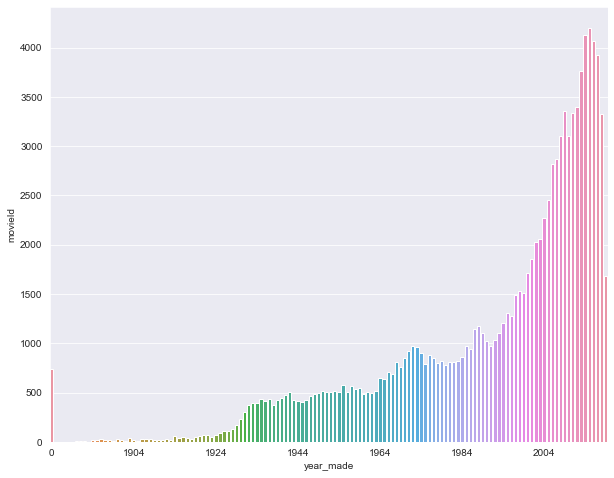

In [9]:
# visualizing how the year of the movies are distributed
df_mov_year = df_mov_gen.groupby("year_made").agg({"movieId":"count"}).reset_index()
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(data=df_mov_year,  x="year_made", y="movieId")
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
plt.show()

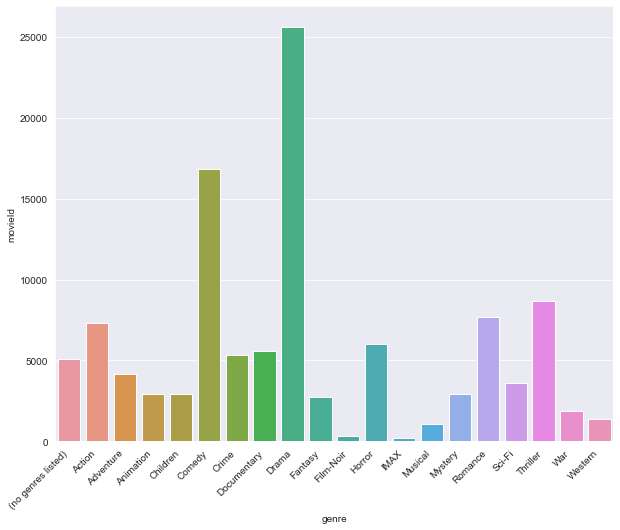

In [10]:
# visualizing how the genres of the movies are distributed
df_grp_gens = df_mov_gen.groupby("genre").agg({"movieId":"count"}).reset_index()
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(data=df_grp_gens,  x="genre", y="movieId")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

#### Creating a `word-cloud` for title of movies base on the `genres`

In [11]:
def bag_of_words_count(words, splitter: str=' ',  word_dict={}):
    """ this function takes in a list of words and returns a dictionary
        with each word as a key, and the value represents the number of
        times that word appeared"""
    words = words.split(splitter)
    for word in words:
        if word in word_dict.keys():
            word_dict[word] += 1
        else:
            word_dict[word] = 1
    return word_dict

In [12]:
def word_extract(df=df_mov_gen, coln: str='title', splitter=' '):
    """This use to compile all the word and there frequency 
    in the individual category found in a particular column"""
#     count = 0
    result = {}
    type_labels = df.genre.unique()
    genres_dict = {}
    df_grp = df.groupby('genre')
    for pp in type_labels:
        genres_dict[pp] = {}
        for row in df_grp.get_group(pp)[coln]:
            genres_dict[pp] = bag_of_words_count(words=row, splitter=splitter, word_dict=genres_dict[pp])
    return genres_dict

In [13]:
# Interactive plotting
def iplotting():
    d = word_extract()
    @interact_manual
    def selecting(genre_name = d.keys()):
        word_cloud_genre=WordCloud(width=1500, height=800, background_color='black', min_font_size=2,
                        min_word_length=3).generate(str(d[genre_name]))
        plt.figure(figsize=(20,10))
        plt.axis('off')
        plt.title(f'Word Cloud for {genre_name} Genre Movie titles',fontsize=30)
        plt.imshow(word_cloud_genre);
iplotting()

interactive(children=(Dropdown(description='genre_name', options=('Adventure', 'Animation', 'Children', 'Comed…

### Exploring `train` dataset

Exploring the train dataset to gain insight into the rating of `movies` and there various tags using the `genome scores and tags`

In [14]:
df_genome_scores = df_list[0].copy() # loading & assigning a varaible to the 'genome_scores' dataset
df_genome_tags = df_list[1].copy() # loading & assigning a varaible to the 'genome_tags' dataset
df_train = df_list[8].copy() # loading & assigning a varaible to the 'train' dataset


Merging the three dataframe plus `movies` dataset above to make one fine and informed dataframe

In [15]:
# Combining dataframe 'df_genome_scores' and 'df_genome_tags'
genome_comb = df_genome_scores.merge(df_genome_tags, how="left", on=["tagId"])
display(genome_comb.shape)
genome_comb.head(10)

(15584448, 4)

,movieId,tagId,relevance,tag
0,1,1,0.02875,007
1,1,2,0.02375,007 (series)
2,1,3,0.06250,18th century
3,1,4,0.07575,1920s
4,1,5,0.14075,1930s
5,1,6,0.14675,1950s
6,1,7,0.06350,1960s
7,1,8,0.20375,1970s
8,1,9,0.20200,1980s
9,1,10,0.03075,19th century


In [16]:
# grouping by 'movieId' and by calculating maximum 'relevance' corresponding to know the actual 'tag' of a 'movie'
genome_grp = genome_comb.groupby('movieId')[["relevance"]].max().reset_index()
display(genome_grp.shape)
genome_grp.head()

(13816, 2)

,movieId,relevance
0,1,0.99925
1,2,0.97600
2,3,0.97525
3,4,0.97525
4,5,0.96025


In [17]:
# Combinig the the grouped dataframe with the original dataframe to match each 'tag' to it respecitive 'relevance'
genome_comb1 = genome_grp.merge(genome_comb[['movieId', 'relevance', 'tag']], on=["movieId", "relevance"])

# drop duplicates to have a sync. merge of movie and `tag` and unccessary 'relevance' column
genome_comb1 = genome_comb1.drop_duplicates(subset=['movieId'])
genome_comb1 = genome_comb1.drop('relevance', axis=1)

genome_comb1.head()

,movieId,tag
0,1,toys
1,2,adventure
2,3,sequel
3,4,women
4,5,sequel


In [18]:
# merging ealier dataframe 'df_comb2' with tag and movie dataframe 'df_gem_comb1'
train_tags = df_train.merge(genome_comb1, how='left', on=["movieId"])
display(train_tags.shape)
train_tags.head(10)

(10000038, 5)

,userId,movieId,rating,timestamp,tag
0,5163,57669,4.0,1518349992,hit men
1,106343,5,4.5,1206238739,sequel
2,146790,5459,5.0,1076215539,alien
3,106362,32296,2.0,1423042565,sequels
4,9041,366,3.0,833375837,horror
5,120949,81768,3.0,1289595242,NaN
6,19630,62049,4.0,1246729817,george orwell
7,21066,2282,1.0,945785907,weird
8,117563,120474,4.0,1515108225,toys
9,144018,1997,5.0,1109967647,horror


In [19]:
#combining dataframe in index 8 and index 4 from the df_list
train_comb = train_tags.merge(df_movies, how="inner", on=["movieId"])
display(train_comb.shape)
train_comb.head(10)

(10000038, 8)

,userId,movieId,rating,timestamp,tag,title,genres,year_made
0,5163,57669,4.0,1518349992,hit men,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008
1,87388,57669,3.5,1237455297,hit men,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008
2,137050,57669,4.0,1425631854,hit men,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008
3,120490,57669,4.5,1408228517,hit men,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008
4,50616,57669,4.5,1446941640,hit men,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008
5,99887,57669,0.5,1448839196,hit men,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008
6,120194,57669,4.5,1479382352,hit men,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008
7,847,57669,3.5,1232893563,hit men,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008
8,47201,57669,4.5,1464351173,hit men,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008
9,94499,57669,4.5,1316689295,hit men,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008


In [20]:
# Checking for null value after merging
train_comb.isnull().sum()

userId            0
movieId           0
rating            0
timestamp         0
tag          130490
title             0
genres            0
year_made         0
dtype: int64

The tag features have a few null value in comparism with the large dataset, we will go ahead to replace those null values with keyword `unknown`

In [21]:
# making each genres into a list to be able to split
train_comb['tag'] = train_comb['tag'].fillna('unknown')

#### Converting the timestampe into `datetime` datatype and aslo into new features

In [22]:
train_comb['Rating_Datetime'] = pd.to_datetime(train_comb['timestamp'], unit='s')
train_comb.drop('timestamp', axis=1, inplace=True)

In [23]:
train_comb.head()

,userId,movieId,rating,tag,title,genres,year_made,Rating_Datetime
0,5163,57669,4.0,hit men,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008,2018-02-11 11:53:12
1,87388,57669,3.5,hit men,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008,2009-03-19 09:34:57
2,137050,57669,4.0,hit men,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008,2015-03-06 08:50:54
3,120490,57669,4.5,hit men,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008,2014-08-16 22:35:17
4,50616,57669,4.5,hit men,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008,2015-11-08 00:14:00


In [24]:
train_comb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000038 entries, 0 to 10000037
Data columns (total 8 columns):
 #   Column           Dtype         
---  ------           -----         
 0   userId           int64         
 1   movieId          int64         
 2   rating           float64       
 3   tag              object        
 4   title            object        
 5   genres           object        
 6   year_made        object        
 7   Rating_Datetime  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 686.6+ MB


In [25]:
# Converting 'year_made' into numeric datatype
train_comb["year_made"] = train_comb["year_made"].astype('int64')

In [26]:
# Let's have a look at the unique number of users
train_comb[["userId"]].nunique() 

userId    162541
dtype: int64

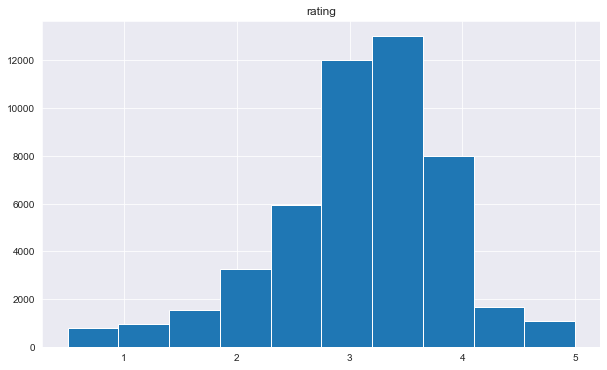

In [27]:
# distribution of mean rating
rating_grp = train_comb.groupby("movieId")[["rating"]].mean()
rating_grp.hist(figsize=(10, 6));

Bulk of the rating are between the value of `3-4` which bascially informed us while the dristibution is `left skewed`

In [28]:
# Group all 2 star and lower ratings together
ratings = train_comb.copy()
ratings[ratings.rating == 0.5] = 2
ratings[ratings.rating == 1] = 2
ratings[ratings.rating == 1.5] = 2

In [29]:
def viza(title: str):
    # Extract selected movie ratings
    top = ratings[ratings['title'] == title]

    # Count how many ratings are in each category: 1 star, 2 star, ect
    grouped = pd.DataFrame(top.groupby(['rating'])['title'].count())
    grouped.rename(columns={'title': 'rating_count'}, inplace=True)

    # Create the figure
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(122)

    # Create the colour palette
    temp = grouped['rating_count']
    temp_mod = [f'{round((x / sum(temp)) * 100)}%' for x in temp]
    labels = [f'{x} Stars - {y}' for x, y in zip(grouped.index, temp_mod)]
    theme = plt.get_cmap('Reds')
    ax.set_prop_cycle("color", [theme(1. * i / len(labels))
                                for i in range(len(labels))])

    # Create the pie chart
    pie = ax.pie(grouped['rating_count'],
                 labels=labels,
                 shadow=True,
                 startangle=10,
                 pctdistance=1.115,
                 explode=(random.choice([0.1], size=(len(grouped['rating_count']))))
                 )

    # Turn the pie chart into a donut chart
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # Display the donut chart with a legend
    ax.set_title(f'Rating distribution for the {title}\n', fontsize=15)
    plt.tight_layout()
    plt.show()

In [30]:
# Interactive visual how movie fair via user ratings
def iplotting_rating():
    genres_df = df_mov_gen.groupby('genre')[['title']]
    genres = df_mov_gen.genre.unique()
#     titles=genres_df.get_group(gen)
    @interact
    def selecting(genres=genres):
        titles = genres_df.get_group(genres)['title'].to_list()
        @interact_manual
        def selecting1(titles=titles):
            viza(titles)
iplotting_rating()


interactive(children=(Dropdown(description='genres', options=('Adventure', 'Animation', 'Children', 'Comedy', …

#### Exploring `imdb_data` DataFrame

In [31]:
# combining dataframe in index 2 from the df_list and current train merged 'train_comb' to give
# an enrich dataset for exploration of 'imdb data'
df_imdb = df_list[2].merge(train_comb, how="inner", on=["movieId"])
display(df_imdb.shape)
df_imdb.head()

(9633031, 13)

,movieId,title_cast,director,runtime,budget,plot_keywords,userId,rating,tag,title,genres,year_made,Rating_Datetime
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,158849,5.0,toys,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995,2001-07-09 22:13:06
1,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,97203,5.0,toys,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1999-11-15 16:25:55
2,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,161871,3.0,toys,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1996-05-26 09:56:16
3,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,45117,4.0,toys,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995,2015-09-14 18:56:09
4,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,27431,5.0,toys,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1996-12-04 02:50:27


In [32]:
# Checking for null values
df_imdb.isnull().sum()

movieId                  0
title_cast         2604407
director           2602688
runtime            2653058
budget             3152276
plot_keywords      2610043
userId                   0
rating                   0
tag                      0
title                    0
genres                   0
year_made                0
Rating_Datetime          0
dtype: int64

In [33]:
# Dropping null values to have a better unbiased analysis of the dataset
df_imdb = df_imdb.dropna(subset=['budget', 'runtime', 'plot_keywords', 'title_cast'])

# Checking for null values again
df_imdb.isnull().sum()

movieId            0
title_cast         0
director           0
runtime            0
budget             0
plot_keywords      0
userId             0
rating             0
tag                0
title              0
genres             0
year_made          0
Rating_Datetime    0
dtype: int64

In [34]:
print(f'We have {df_imdb.userId.nunique()} numbers of users in the new and modified "imdb" dataset and\
      \nWe also have {df_imdb.movieId.nunique()} number of movies to explore YAY!!!')

print(f'The dataset has {df_imdb.shape[0]} rows/entries and {df_imdb.shape[1]} features/columns') 

We have 162182 numbers of users in the new and modified "imdb" dataset and      
We also have 6418 number of movies to explore YAY!!!
The dataset has 6454993 rows/entries and 13 features/columns


#### Engineer new features for the `IMDB` dataset

In [35]:
df_imdb['rated_year'] = pd.DatetimeIndex(df_imdb['Rating_Datetime']).year
df_imdb['rated_month'] = pd.DatetimeIndex(df_imdb['Rating_Datetime']).month
df_imdb['rated_day'] = pd.DatetimeIndex(df_imdb['Rating_Datetime']).day
df_imdb.drop('Rating_Datetime', axis=1, inplace=True)

In [36]:
df_imdb.sample(5)

,movieId,title_cast,director,runtime,budget,plot_keywords,userId,rating,tag,title,genres,year_made,rated_year,rated_month,rated_day
3314251,1544,Jeff Goldblum|Julianne Moore|Pete Postlethwait...,Michael Crichton,129.0,"$73,000,000",dinosaur|costa rica|dog's death|blockbuster video,155563,4.0,dinosaurs,"Lost World: Jurassic Park, The (1997)","[Action, Adventure, Sci-Fi, Thriller]",1997,2016,10,4
1961270,852,Kevin Costner|Rene Russo|Don Johnson|Cheech Ma...,John Norville,135.0,"$45,000,000",golf|nickname|love|kiss,1475,3.0,golf,Tin Cup (1996),"[Comedy, Drama, Romance]",1996,2008,8,23
1810148,736,Helen Hunt|Bill Paxton|Cary Elwes|Jami Gertz|P...,Michael Crichton,113.0,"$92,000,000",eating|steak|crashing a car into a house|cow,120696,1.0,natural disaster,Twister (1996),"[Action, Adventure, Romance, Thriller]",1996,2008,10,19
7988186,43928,Milla Jovovich|Cameron Bright|Nick Chinlund|Se...,Kurt Wimmer,88.0,"$30,000,000",terrible dialogue|bad acting|bare midriff|bare...,57734,2.0,based on a comic,Ultraviolet (2006),"[Action, Fantasy, Sci-Fi, Thriller]",2006,2007,9,13
5819611,3950,Colin Farrell|Matthew Davis|Clifton Collins Jr...,Ross Klavan,101.0,"$10,000,000",vietnam|platoon|recruit|sergeant,148149,2.0,vietnam war,Tigerland (2000),[Drama],2000,2010,7,1


#### Important  words for `Plot` and `Cast`

In [37]:
def imdb_extract(coln: str, splitter='|', df=df_imdb):
    """This use to compile all the keyword and there frequency 
    in the imdb dataset found in a particular column"""
    keywords_dict = {}
    movieId = df.movieId.unique()
    df_grp = df_imdb.groupby('movieId')
    for pp in movieId:
        row = df_grp.get_group(pp)[coln].values[0]
        keywords_dict = bag_of_words_count(words=row, splitter=splitter, word_dict=keywords_dict)
        
#     Sorting the dictionary
    sorted_dt = {key: value for key, value in sorted(keywords_dict.items(), key=lambda item: item[1], reverse=True)}
    return sorted_dt

In [38]:
# making a dictionary for the keyword and there frequency
keyword_dict = imdb_extract(coln='plot_keywords')

# making a dictionary for the cast (actors and actress) and there frequency
casts_dict = imdb_extract(coln='title_cast')

In [39]:
def iplotting():   
    slider = widgets.IntSlider(value=25, min=10, max=50, step=1)
    @interact_manual
    def selecting(WordType=['Plot Keywords', 'Title Cast'], Frequency=slider, ):
        if WordType == 'Title Cast':
            num_dict_items = dict(itertools.islice(casts_dict.items(), Frequency))
        else:
            num_dict_items = dict(itertools.islice(keyword_dict.items(), Frequency))
        word_cloud_genre=WordCloud(width=1500, height=800, background_color='white',
                                   relative_scaling=0.2, min_font_size=2,).generate_from_frequencies(num_dict_items)
        plt.figure(figsize=(20,10))
        plt.axis('off')
        plt.title(f'{WordType} for Movies',fontsize=30)
        plt.imshow(word_cloud_genre);
iplotting()

interactive(children=(Dropdown(description='WordType', options=('Plot Keywords', 'Title Cast'), value='Plot Ke…

#### Movie Runtime Distribution

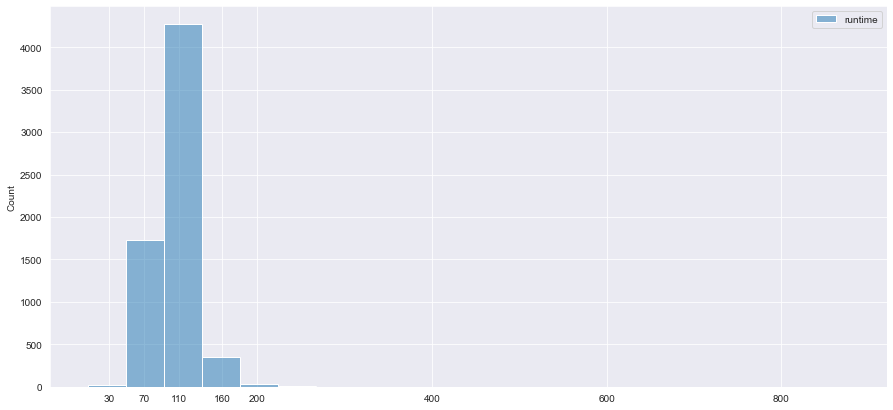

In [40]:
runtime_df = df_imdb.groupby('movieId')[['runtime']].mean()
plt.figure(figsize=(15, 7))
sns.histplot(runtime_df, bins=20)
plt.xticks([30, 70, 110, 160, 200, 400, 600, 800])
plt.show()

The `runtime` shows that bulk of movies are between `70-110 minutes` durations<br>
while from `300 minutes` movies and `upwards` are rare and can be considered outliers

#### Budget VS Rating
Visual for budget and how it affect rating by `users`

In [41]:
# Converting budget into numeric datatype
df_imdb['budget_currency'] = df_imdb.budget.apply(lambda x: re.match('[^0-9]+', x).group(0))
df_imdb['budgets'] = df_imdb.budget.apply(lambda x: x.replace(re.match('[^0-9]+', x).group(0), ''))
df_imdb['budgets'] = df_imdb.budgets.apply(lambda x: x.replace(',', '')).astype('float64')


In [42]:
# Lisiting all currency in our dataset
currency = df_imdb.budget_currency.unique()
currency

array(['$', 'GBP', 'EUR', 'CAD', 'FRF', 'DEM', 'AUD', 'JPY', 'HKD', 'CHF',
       'ESP', 'INR', 'BEF', 'SEK', 'ATS', 'NOK', 'FIM', 'SGD', 'DKK',
       'THB', 'BRL', 'NLG', 'BND', 'CNY', 'NZD', 'HUF', 'KRW', 'CZK',
       'PLN', 'ISK', 'BGL', 'IDR', 'MYR', 'CLP', 'MXN', 'ARS', 'ILS',
       'PTE', 'VEB', 'TWD', 'NGN', 'ITL', 'LVL', 'RUR', 'PHP'],
      dtype=object)

In [43]:
# Importing current exchange rate from `exchangerate-api.com`
url = 'https://open.er-api.com/v6/latest/USD'
data = requests.get(url).json()
currencies = data['rates']

In [44]:
# currency not in the json file
for x in currency:
    if x not in currencies:
        print(x, end=",")

$,FRF,DEM,ESP,BEF,ATS,FIM,NLG,BGL,PTE,VEB,ITL,LVL,RUR,

In [45]:
# inputing manually for currency not so popular and not in the json file
other_curr = {'$':1, 'FRF':0.155, 'DEM':0.52, 'ESP':1.02, 'BEF':0.025, 'ATS':0.074, 
              'FIM':0.17, 'NLG':0.46, 'BGL':0.52, 'PTE':0.00508, 'VEB':0.0000000018,
              'ITL':0.000526, 'LVL':1.449,'RUR':0.016,}

In [46]:
# appending exchange rate against dollar to a dictionary
currency_exchange = {}
for x in currency:
    currency_exchange[x] = (currencies | other_curr)[x]
# currency_exchange

In [47]:
# Grouping to movies and converting all currency to 'USD'
movie_grp = df_imdb.groupby('movieId').agg({"rating":"mean",
                                            "budget_currency":lambda x: pd.Series.mode(x)[0], "budgets":"mean"})
movie_grp['conv_budget'] = movie_grp.apply(lambda x: round(x.budgets/currency_exchange[x.budget_currency]), axis=1)
movie_grp.sample(10)

,rating,budget_currency,budgets,conv_budget
movieId,,,,
101025,2.996364,$,195000000.0,195000000
2325,3.118056,$,1000000.0,1000000
105,3.318596,$,24000000.0,24000000
47423,3.655832,$,700000.0,700000
87449,3.333333,EUR,3675000.0,3697183
51935,3.621007,$,61000000.0,61000000
88194,2.625000,$,1300000.0,1300000
91290,3.522222,EUR,10000000.0,10060362
6337,3.492991,$,10000000.0,10000000


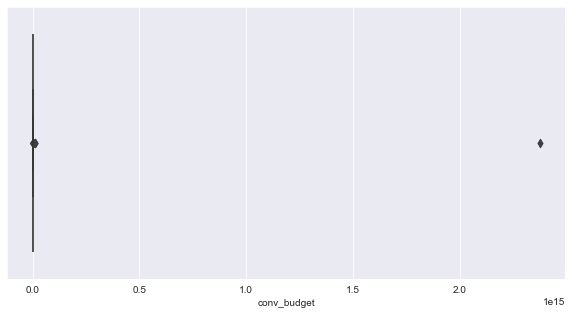

In [48]:
# Using visual to check for outliers
fig, ax = plt.subplots(1, figsize=(10,5))
sns.boxenplot(x='conv_budget', data=movie_grp);


This visual show us there is extreme outlier(s) in the dataset and will have bad influence on the intepretation of following visuals, therefore we need to remove those `outliers`

In [49]:
# Dealing with outliers, since we have an outrageous one in our dataset
Q1 = np.percentile(movie_grp['conv_budget'], 25.0)
Q3 = np.percentile(movie_grp['conv_budget'], 75.0)
IQR = Q3 - Q1
df_sub = movie_grp[movie_grp['conv_budget'] > Q3 + 1.5*IQR]
movie_grp_mod = movie_grp.drop(df_sub.index)

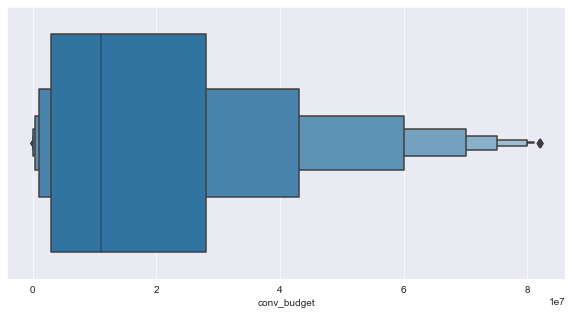

In [50]:
# Using visual to check again for outliers
fig, ax = plt.subplots(1, figsize=(10,5))
sns.boxenplot(x='conv_budget', data=movie_grp_mod);

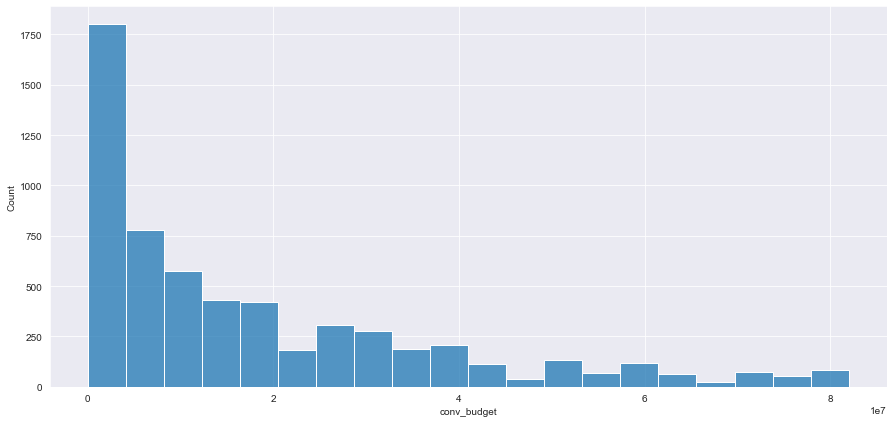

In [51]:
# Visualize the distribution of the movies budgets
plt.figure(figsize=(15, 7))
sns.histplot(x=movie_grp_mod['conv_budget'], bins=20)
plt.show()

The histogram show that our budget is skewed to the right, and dipect, we have lesser film has cost of movie `budget` increases

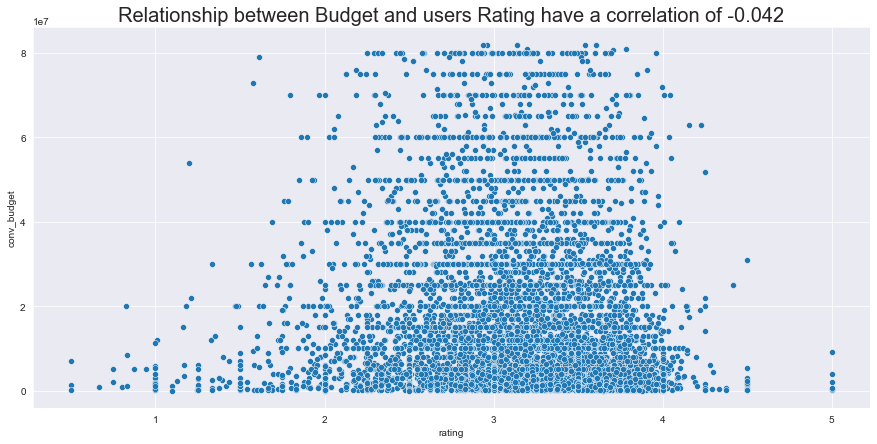

In [52]:
# Plotting a scatter plot to visualize relationship between 
plt.figure(figsize=(15, 7))
sns.scatterplot(data=movie_grp_mod, y='conv_budget', x='rating');
plt.title(f'Relationship between Budget and users Rating have a\
 correlation of {round(movie_grp_mod.conv_budget.corr(movie_grp_mod.rating),4)}', fontsize=20)
plt.show()

Though there might be some correlation between `budgets and rating` it is very `weak` and it is safe to assume that money used in making film does not really have much impart into what inform users ratings

#### Simple Recommender System
- Using the year movie was made, ratings and each movies number of rating or voting to filter and rank movies to see what people are watching or get list of trendy films<br><br>
Since we want to include the whole users input from the dataset we will go back to our earlier `train combined dataset (train_comb)` and use that to create new features, which we will then use in ranking `movies`

In [53]:
# Creating new features 'rating_average' and 'rating_count' per each movies in our dataset
movie_ranking_df = pd.DataFrame(train_comb.groupby(['title'])[['rating']].agg(
    rating_average=('rating',np.mean), 
    rating_count=('rating','count')))

# Using the product of the new features to create another feature call 'popularity'
movie_ranking_df['popularity'] = movie_ranking_df['rating_average'] * movie_ranking_df['rating_count']

# extracting the year in which the movie was made to create new features
movie_ranking_df.reset_index(inplace=True)
movie_ranking_df["year_made"] = movie_ranking_df["title"].apply(lambda x: "".join(re.findall(r"\((\d+)\)+$", x)) 
                                                  if re.findall(r"\((\d+)\)+$", x) else 0)

movie_ranking_df.sort_values('rating_count', ascending=False).head()

,title,rating_average,rating_count,popularity,year_made
34480,"Shawshank Redemption, The (1994)",4.417624,32831,145035.0,1994
14537,Forrest Gump (1994),4.047216,32383,131061.0,1994
31236,Pulp Fiction (1994),4.195097,31697,132972.0,1994
34840,"Silence of the Lambs, The (1991)",4.144172,29444,122021.0,1991
25144,"Matrix, The (1999)",4.154253,29014,120531.5,1999


We will use the TMDB Ratings to come up with our **Top Movies Chart.** using the IMDB's *weighted rating* formula to construct the ranks. Mathematically, it is represented as follows:

Weighted Rating (WR) = $(\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$

where,
* *v* is the number of votes for the movie
* *m* is the minimum votes required to be listed in the chart
* *R* is the average rating of the movie
* *C* is the mean vote across the whole report

The next step is to determine an appropriate value for *m*, the minimum votes required to be listed in the chart. We will use **95th percentile** as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 95% of the movies in the list.def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

qualified['wr'] = qualified.apply(weighted_rating, axis=1)

qualified = qualified.sort_values('wr', ascending=False).head(250)

### Top Movies

qualified.head(15)

We see that three Christopher Nolan Films, **Inception**, **The Dark Knight** and **Interstellar** occur at the very top of our chart. The chart also indicates a strong bias of TMDB Users towards particular genres and directors. 

Let us now construct our function that builds charts for particular genres. For this, we will use relax our default conditions to the **85th** percentile instead of 95. 

In [54]:
# Attempt to create the formular above
vote_counts = movie_ranking_df[movie_ranking_df['rating_count'].notnull()]['rating_count'].astype('int')
vote_averages = movie_ranking_df[movie_ranking_df['rating_average'].notnull()]['rating_average'].astype('int')
C = vote_averages.mean()
m = vote_counts.quantile(0.95)
print(f'The mean rating for the whole dataset is {round(C, 2)} and minimum votes required to be listed is {round(m)}')

The mean rating for the whole dataset is 2.7 and minimum votes required to be listed is 816


In [55]:
movie_ranking_df.head()

,title,rating_average,rating_count,popularity,year_made
0,"""BLOW THE NIGHT!"" Let's Spend the Night Togeth...",3.000000,1,3.0,1983
1,"""Great Performances"" Cats (1998)",2.753731,67,184.5,1998
2,#1 Cheerleader Camp (2010),1.900000,5,9.5,2010
3,#Female Pleasure (2018),4.000000,1,4.0,2018
4,#FollowMe (2019),2.400000,5,12.0,2019


In [56]:
# creating a function to calculate the weighting rating as recommended by IMDB
def weighted_rating(x, mini=m, avg_votes=C):
    votes = x['rating_count']
    avg_rating = x['rating_average']
    return (votes/(votes+mini) * avg_rating) + (mini/(mini+votes) * avg_votes)

In [57]:
# Creating th feature 'weighted_rating'
movie_ranking_df['weighted_rating'] = movie_ranking_df.apply(weighted_rating, axis=1)

movie_ranking_df.sort_values('weighted_rating', ascending=False).head()


,title,rating_average,rating_count,popularity,year_made,weighted_rating
34480,"Shawshank Redemption, The (1994)",4.417624,32831,145035.0,1994,4.375983
15944,"Godfather, The (1972)",4.311355,20960,90366.0,1972,4.251000
45118,"Usual Suspects, The (1995)",4.278073,22032,94254.5,1995,4.221739
33688,Schindler's List (1993),4.247625,24004,101960.0,1993,4.196769
15945,"Godfather: Part II, The (1974)",4.274085,13525,57807.0,1974,4.184562


In [58]:
# Creating a dataframe for movies that meet requirement to be in the trend or ranked list
qualify_df = movie_ranking_df[(movie_ranking_df['rating_count'] >= m)][['title', 'year_made', 'rating_count',
                                                                        'rating_average', 'popularity', 'weighted_rating']]
qualify_df['rating_count'] = qualify_df['rating_count'].astype('int')
qualify_df['rating_average'] = qualify_df['rating_average'].astype('int')
qualify_df.shape

(2408, 6)

Therefore, to qualify to be considered for the ranked movies, a movie has to have at least **816 ratings** on TMDB. We also see that the average rating for a movie on TMDB is **2.7** on a scale of 5. **2408** Movies qualify to be on our chart.

### Top Movies

In [59]:
qualify_df.sort_values('weighted_rating', ascending=False).head(15)

,title,year_made,rating_count,rating_average,popularity,weighted_rating
34480,"Shawshank Redemption, The (1994)",1994,32831,4,145035.0,4.375983
15944,"Godfather, The (1972)",1972,20960,4,90366.0,4.251000
45118,"Usual Suspects, The (1995)",1995,22032,4,94254.5,4.221739
33688,Schindler's List (1993),1993,24004,4,101960.0,4.196769
15945,"Godfather: Part II, The (1974)",1974,13525,4,57807.0,4.184562
13799,Fight Club (1999),1999,23536,4,99508.0,4.176733
31236,Pulp Fiction (1994),1994,31697,4,132972.0,4.157593
28738,One Flew Over the Cuckoo's Nest (1975),1975,14403,4,60750.5,4.136561
25144,"Matrix, The (1999)",1999,29014,4,120531.5,4.114493
11749,Dr. Strangelove or: How I Learned to Stop Worr...,1964,10673,4,45017.5,4.110135


for easy access and not to be `genre` bias, we will split and match each genre to the appripoate movie, so as to filter by `genre` and see top listed movies

In [60]:
# drop duplicates to have a sync. merge of genres with the dataset
temp_df = df_list[4].drop_duplicates(subset=['title'])

# merging genres with the 'qualify_df'
trend_df = temp_df[['title', 'genres']].merge(qualify_df, how="right", on="title")

# making each genres into a list to be able to split
trend_df['genres'] = trend_df['genres'].fillna('').apply(lambda x: x.split("|"))

# Splitting each genre to each movies
genre = trend_df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
genre.name = 'genre'
qualify_df = trend_df.drop('genres', axis=1).join(genre)
qualify_df.head()

,title,year_made,rating_count,rating_average,popularity,weighted_rating,genre
0,"'burbs, The (1989)",1989,1310,3,4029.5,2.932234,Comedy
1,(500) Days of Summer (2009),2009,4524,3,16780.0,3.555078,Comedy
1,(500) Days of Summer (2009),2009,4524,3,16780.0,3.555078,Drama
1,(500) Days of Summer (2009),2009,4524,3,16780.0,3.555078,Romance
2,10 Cloverfield Lane (2016),2016,1459,3,5421.0,3.351745,Thriller


In [61]:
# visualizing base on genre and other filtering method
def iplotting():   
    slider = widgets.IntSlider(value=10, min=5, max=50, step=1)
    df_grp = qualify_df.groupby('genre')
    genre_list = qualify_df.genre.unique()
    @interact
    def selecting(filterBy=['Recent', 'Popularity', 'Hot-List'], Genre=genre_list, Frequency=slider, ):
        if filterBy == 'Recent':
            temp = df_grp.get_group(Genre).sort_values(['year_made', 'weighted_rating'], ascending=False)[:Frequency]
        elif filterBy == 'Popularity':
            temp = df_grp.get_group(Genre).sort_values(['popularity', 'year_made'], ascending=False)[:Frequency]
        else:
            temp = df_grp.get_group(Genre).sort_values('weighted_rating', ascending=False)[:Frequency]
        display(temp.drop('genre', axis=1).reset_index(drop=True))
iplotting()

interactive(children=(Dropdown(description='filterBy', options=('Recent', 'Popularity', 'Hot-List'), value='Re…

### Preparing Dataset for Recommendation system

In [62]:
# assigning the imdb dataset to a variable
imdb_df = df_list[2].copy()
imdb_df.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [63]:
# spliting and joining the title cast and also picking the first three (3) actors
imdb_df['title_cast'] = imdb_df['title_cast'].fillna('').apply(lambda x: " ". join(x.replace(" ", "").split('|')[:3]))

# spliting and joining the plot keywords
imdb_df['plot_keywords'] = imdb_df['plot_keywords'].fillna('').apply(lambda x: " ". join(x.split('|')))


In [64]:
# assigning the movies dataset to a variable
movies_df = df_list[4].copy()

# spliting and joining the genres keywords
movies_df['genres'] = movies_df['genres'].fillna('').apply(lambda x: " ". join(x.split('|')))

movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [65]:
# merging the imbd movies dataset with movies dataset
imdb_df = imdb_df[["movieId", "title_cast", "director", "plot_keywords"]] # selected features
comb_df = imdb_df.merge(movies_df, how="left", on="movieId")
comb_df.shape

(27278, 6)

In [66]:
# checking for null value
comb_df.isnull().sum()

movieId             0
title_cast          0
director         9874
plot_keywords       0
title            2412
genres           2412
dtype: int64

In [67]:
# drop all row having null value in it 'titlle'
comb_df.dropna(subset='title', inplace=True)

# replacing all 'director' null values into an empty string
comb_df['director'] = comb_df['director'].fillna('')

# checking for null value again
comb_df.isnull().sum()

movieId          0
title_cast       0
director         0
plot_keywords    0
title            0
genres           0
dtype: int64

#### Merging the tags and using `relevance` to pick the most appriopate tag for each movies

In [68]:
# assigning the movies dataset to a variable
tags_df = df_list[0].copy()
display(tags_df.head())

# assigning the movies dataset to a variable
tag_movie_df = df_list[1].copy()
display(tag_movie_df.head())

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [69]:
tag_comb_df = tags_df.merge(tag_movie_df, on="tagId")
display(tag_comb_df.shape)
tag_comb_df.head()

(15584448, 4)

,movieId,tagId,relevance,tag
0,1,1,0.02875,007
1,2,1,0.04125,007
2,3,1,0.04675,007
3,4,1,0.03425,007
4,5,1,0.04300,007


In [70]:
# grouping by 'movieId' and by calculating maximum 'relevance' corresponding to know the actual 'tag' of a 'movie'
tag_grp_df = tag_comb_df.groupby('movieId')[["relevance"]].max().reset_index()
display(tag_grp_df.shape)
tag_grp_df.head()

(13816, 2)

,movieId,relevance
0,1,0.99925
1,2,0.97600
2,3,0.97525
3,4,0.97525
4,5,0.96025


In [71]:
# Combinig the the grouped dataframe with the original dataframe to match each 'tag' to it respecitive 'relevance'
tag_mod_df = tag_grp_df.merge(tag_comb_df[['movieId', 'relevance', 'tag']], how='inner', on=["movieId", "relevance"])

# drop duplicates to have a sync. merge of movie and `tag` and unccessary 'relevance' column
tag_mod_df = tag_mod_df.drop_duplicates(subset=['movieId'])
tag_mod_df = tag_mod_df.drop('relevance', axis=1)

tag_mod_df.head()

,movieId,tag
0,1,toys
1,2,adventure
2,3,sequel
3,4,women
4,5,sequel


#### Merging all the prepared dataset to have a better enriching features

In [72]:
all_df = comb_df.merge(tag_mod_df, how="left", on="movieId")
display(all_df.shape)
all_df.head()

(24866, 7)

,movieId,title_cast,director,plot_keywords,title,genres,tag
0,1,TomHanks TimAllen DonRickles,John Lasseter,toy rivalry cowboy cgi animation,Toy Story (1995),Adventure Animation Children Comedy Fantasy,toys
1,2,RobinWilliams JonathanHyde KirstenDunst,Jonathan Hensleigh,board game adventurer fight game,Jumanji (1995),Adventure Children Fantasy,adventure
2,3,WalterMatthau JackLemmon SophiaLoren,Mark Steven Johnson,boat lake neighbor rivalry,Grumpier Old Men (1995),Comedy Romance,sequel
3,4,WhitneyHouston AngelaBassett LorettaDevine,Terry McMillan,black american husband wife relationship betra...,Waiting to Exhale (1995),Comedy Drama Romance,women
4,5,SteveMartin DianeKeaton MartinShort,Albert Hackett,fatherhood doberman dog mansion,Father of the Bride Part II (1995),Comedy,sequel


In [73]:
# replacing all 'tag' null values into an empty string
all_df['tag'] = all_df['tag'].fillna('')

# checking for null value
all_df.isnull().sum()

movieId          0
title_cast       0
director         0
plot_keywords    0
title            0
genres           0
tag              0
dtype: int64

In [74]:
# all_df.to_csv('recommender_dataset.csv')

## Content-based Filtering 

In [75]:
all_df['concat'] = (pd.Series(all_df[['title_cast', 'director', 'plot_keywords', 'genres', 'tag']]
                      .values.tolist()).str.join(' '))

In [76]:
# Convienient indexes to map between movie titles and indexes of the 'all_df' dataframe
titles = all_df['title']
indices = pd.Series(all_df.index, index=all_df['title'])

In [77]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2),
                     min_df=0, stop_words='english')

# Produce a feature matrix, where each row corresponds to a movie,
# with TF-IDF features as columns 
tf_enrich_matrix = tf.fit_transform(all_df['concat'])

In [78]:
tf_enrich_matrix.shape

(24866, 172751)

In [79]:
cosine_sim_enrich = cosine_similarity(tf_enrich_matrix, 
                                        tf_enrich_matrix)
print (cosine_sim_enrich.shape)

(24866, 24866)


In [80]:
def content_generate_top_N_recommendations(movie_title, N=10):
    # Convert the string movie title to a numeric index for our 
    # similarity matrix
    b_idx = indices[movie_title]
    # Extract all similarity values computed with the reference movie title
    sim_scores = list(enumerate(cosine_sim_enrich[b_idx]))
    # Sort the values, keeping a copy of the original index of each value
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Select the top-N values for recommendation
    sim_scores = sim_scores[1:N]
    # Collect indexes 
    movie_indices = [i[0] for i in sim_scores]
    # Convert the indexes back into titles 
    return titles.iloc[movie_indices]

In [81]:
title = indices.index[random.randint(24866)]
print(f'{title} has this following recommendation')
content_generate_top_N_recommendations(title).head(10)

New Jersey Drive (1995) has this following recommendation


6325                   From the Terrace (1960)
4522                   New York Stories (1989)
2255     Pope of Greenwich Village, The (1984)
10630                       Freedomland (2006)
4864               Moscow on the Hudson (1984)
11888                              Scum (1979)
7291                        Jersey Girl (1992)
16599                   Laws of Gravity (1992)
1754                            Illtown (1996)
Name: title, dtype: object

#### Getting the train dataset ready for rating predictions

In [83]:
train_df = df_list[8].merge(all_df, how="left", on='movieId')
display(train_df.shape)
train_df.head()

(10000038, 11)

,userId,movieId,rating,timestamp,title_cast,director,plot_keywords,title,genres,tag,concat
0,5163,57669,4.0,1518349992,ElizabethBerrington RudyBlomme OlivierBonjour,Martin McDonagh,dwarf bruges irish hitman,In Bruges (2008),Comedy Crime Drama Thriller,hit men,ElizabethBerrington RudyBlomme OlivierBonjour ...
1,106343,5,4.5,1206238739,SteveMartin DianeKeaton MartinShort,Albert Hackett,fatherhood doberman dog mansion,Father of the Bride Part II (1995),Comedy,sequel,SteveMartin DianeKeaton MartinShort Albert Hac...
2,146790,5459,5.0,1076215539,TommyLeeJones WillSmith RipTorn,Lowell Cunningham,lingerie michael jackson character shorthaired...,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action Comedy Sci-Fi,alien,TommyLeeJones WillSmith RipTorn Lowell Cunning...
3,106362,32296,2.0,1423042565,SandraBullock ReginaKing EnriqueMurciano,Marc Lawrence,female protagonist cleave gag good woman fbi,Miss Congeniality 2: Armed and Fabulous (2005),Adventure Comedy Crime,sequels,SandraBullock ReginaKing EnriqueMurciano Marc ...
4,9041,366,3.0,833375837,JeffDavis HeatherLangenkamp MikoHughes,Wes Craven,freddy krueger elm street famous director as h...,Wes Craven's New Nightmare (Nightmare on Elm S...,Drama Horror Mystery Thriller,horror,JeffDavis HeatherLangenkamp MikoHughes Wes Cra...


In [84]:
train_df = train_df.fillna('')

In [85]:
def content_generate_rating_estimate(movie_title, user, rating_data, k=20, threshold=0.0):
    # Convert the book title to a numeric index for our 
    # similarity matrix
    b_idx = indices[movie_title]
    neighbors = [] # <-- Stores our collection of similarity values 
     
    # Gather the similarity ratings between each book the user has rated
    # and the reference book 
    for index, row in rating_data[rating_data['userId']==user].iterrows():
        if row['title']:
            sim = cosine_sim_enrich[b_idx-1, indices[row['title']]-1]
        else:
            pass
        if type(sim) == np.ndarray:
            sim = sim[1]
        neighbors.append((sim, row['rating']))
#     print(type(sim))
#     print(neighbors)
    # Select the top-N values from our collection
    k_neighbors = heapq.nlargest(k, neighbors, key=lambda t: t[0])

    # Compute the weighted average using similarity scores and 
    # user item ratings. 
    simTotal, weightedSum = 0, 0
    for (simScore, rating) in k_neighbors:
        # Ensure that similarity ratings are above a given threshold
        if (simScore > threshold):
            simTotal += simScore
            weightedSum += simScore * rating
    try:
        predictedRating = weightedSum / simTotal
    except ZeroDivisionError:
        # Cold-start problem - No ratings given by user. 
        # We use the average rating for the reference item as a proxy in this case 
        predictedRating = np.mean(rating_data[rating_data['title']==movie_title]['rating'])
    return predictedRating

In [86]:
# Subset of ratings from user 314
train_df[train_df['userId'] == 314][['title', 'rating', 'director']]

,title,rating,director
27693,Wyatt Earp (1994),4.0,Dan Gordon
532328,Mission: Impossible (1996),3.0,Bruce Geller
1280594,Forrest Gump (1994),4.0,Winston Groom
1950657,Much Ado About Nothing (1993),5.0,William Shakespeare
2118680,First Knight (1995),4.0,Lorne Cameron
2146227,"Remains of the Day, The (1993)",3.0,Kazuo Ishiguro
2733246,Persuasion (1995),5.0,Roger Michell
3073295,"Three Musketeers, The (1993)",3.0,Alexandre Dumas
3541280,I.Q. (1994),4.0,Andy Breckman
4747038,Independence Day (a.k.a. ID4) (1996),3.0,Dean Devlin


We first generate some ratings for books which user 314 has already rated:

In [87]:
title = "Three Musketeers, The (1993)"
actual_rating = train_df[(train_df['userId'] == 314) & (train_df['title'] == title)]['rating'].values[0]
pred_rating = content_generate_rating_estimate(movie_title=title, user=314, rating_data=train_df)
print (f"Title - {title}")
print ("---")
print (f"Actual rating: \t\t {actual_rating}")
print (f"Predicted rating: \t {pred_rating}")

Title - Three Musketeers, The (1993)
---
Actual rating: 		 3.0
Predicted rating: 	 3.02615994556119


In [88]:
title = "Fugitive, The (1993)"
actual_rating = train_df[(train_df['userId'] == 314) & (train_df['title'] == title)]['rating'].values[0]
pred_rating = content_generate_rating_estimate(movie_title=title, user=314, rating_data=train_df)
print (f"Title - {title}")
print ("---")
print (f"Actual rating: \t\t {actual_rating}")
print (f"Predicted rating: \t {pred_rating}")

Title - Fugitive, The (1993)
---
Actual rating: 		 5.0
Predicted rating: 	 4.919284002527432


In [89]:
title = indices.index[random.randint(24866)]
actual = train_df.loc[((train_df['userId'] == 314) & (train_df['title'] == title))]
pred_rating = content_generate_rating_estimate(movie_title=title, user=314, rating_data=train_df)
print (f"Title - {title}")
print ("---")
if actual.shape[0]:
    actual_rating = actual['rating'].values[0]
    print (f"Actual rating: \t\t {actual_rating}")
else:
    print (f"Actual rating: \t\t ?")
print (f"Predicted rating: \t {pred_rating}")

Title - Igby Goes Down (2002)
---
Actual rating: 		 ?
Predicted rating: 	 3.803239654527025


## Collaborative Filtering

Our content based engine suffers from some severe limitations. It is only capable of suggesting movies which are *close* to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who s/he is.

Therefore, in this section, we will use a technique called **Collaborative Filtering** to make recommendations to Movie Watchers. Collaborative Filtering is based on the idea that users similar to a me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.

I will not be implementing Collaborative Filtering from scratch. Instead, I will use the **Surprise** library that used extremely powerful algorithms like **Singular Value Decomposition (SVD)** to minimise RMSE (Root Mean Square Error) and give great recommendations.

In [ ]:
reader = Reader()

In [ ]:
ratings = df_list[8]
ratings.head()

In [ ]:
X_train, X_test = train_test_split(ratings, test_size=0.9, random_state=0)

In [ ]:
X_test.shape

In [ ]:
# data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [ ]:
# model = SVD()
# # model.fit(data)
# cross_validate(model, data, measures=['rmse', 'mae'], cv=3)

In [ ]:
trainsets = data.build_full_trainset()
# model.fit(trainsets)

In [ ]:
# We make use of an SVD model trained on a subset of the MovieLens 10k dataset.
model=pickle.load(open('resources/models/svd_custom_model.pkl', 'rb'))

In [ ]:
X_train[X_train['userId'] == 2]

In [ ]:
model.predict(2, 314, 5)

In [ ]:
model_save_path = "svd_custom_model.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(model, file)

In [ ]:
test_df = df_list[7]
test_df.head()

In [ ]:
# # Train the model on the entire dataset 
# reader = Reader(rating_scale=(0.5, 5))
# data = Dataset.load_from_df(train[['userId','movieId','rating']], reader)
# trainingSet = data.build_full_trainset()
# svd.fit(trainingSet)

# Make predictions using the trained model
pred = [model.predict(test_df.userId[i], test_df.movieId[i]).est for i in test_df.index]
test_df['rating'] = pred

In [ ]:
# Create the csv file for submission
test_df['Id'] = test_df['userId'].astype(str)+'_'+test_df['movieId'].astype(str)
test_df = test_df[['Id','rating']]
test_df.to_csv('submission.csv', index=False)

trial1

In [142]:
ratings_df = pd.read_csv('resources/data/ratings.csv')
ratings_df.drop(['timestamp'], axis=1,inplace=True)

In [143]:
# We make use of an SVD model trained on a subset of the MovieLens 10k dataset.
model=pickle.load(open('resources/models/baselineOnly.pkl', 'rb'))

In [144]:
model.predict(2, 314, 5)

Prediction(uid=2, iid=314, r_ui=5, est=3.6372448521783283, details={'was_impossible': False})

In [146]:
reader = Reader()
load_df = Dataset.load_from_df(ratings_df, reader)
a_train = load_df.build_full_trainset()

In [147]:
# decoy
df = df_list[4][:27000]
df.sample(10)

,movieId,title,genres
24473,121577,Revolt of the Praetorians (1964),Action|Adventure|Drama
23773,119305,The Nutcracker Prince (1990),Adventure|Animation|Children|Fantasy
3915,4019,Finding Forrester (2000),Drama
22067,113317,Before Winter Comes (1969),Comedy|Drama|War
14666,77818,Gunless (2010),Action|Comedy|Drama|Western
24955,122679,"John Goldfarb, Please Come Home! (1965)",(no genres listed)
26621,126747,Lotta på Bråkmakargatan (1992),Children
23626,118774,The Widow From Chicago (1930),Crime|Drama|Romance
24847,122441,Tales That Witness Madness (1973),Comedy|Horror|Mystery|Sci-Fi
1248,1281,"Great Dictator, The (1940)",Comedy|Drama|War


In [148]:
df.loc[df['title']=='Room for Romeo Brass, A (1999)', 'movieId'].values[0]

41712

In [162]:
movie_list = [113317, 1281, 53476]
predictions = []
id_store = []
for iid in movie_list:
    for ui in a_train.all_users():
        predictions.append(model.predict(iid=iid, uid=ui, verbose=False))
    predictions.sort(key=lambda x: x.est, reverse=True)
    # Take the top 10 user id's from each movie with highest rankings
    for pred in predictions[:50]:
        id_store.append(pred.uid)

In [163]:
pred_users = ratings_df[ratings_df['userId'].isin(id_store)]
display(pred_users.shape)
pred_users.head()

(6606, 3)

,userId,movieId,rating
7252,44,1,4.0
7253,44,3,5.0
7254,44,5,3.0
7255,44,6,3.0
7256,44,17,2.0


In [164]:
df3 = pred_users.merge(df_list[4], on='movieId')
df3_mod = df3.groupby('title').agg(rating_count=('rating', 'count'), 
                                   rating_mean=('rating', 'mean'))
df3_mod.head()

,rating_count,rating_mean
title,,
"'burbs, The (1989)",1,2.000000
'night Mother (1986),1,5.000000
(500) Days of Summer (2009),5,3.800000
...And Justice for All (1979),2,4.500000
10 Things I Hate About You (1999),3,3.666667


In [165]:
# Attempt to create the formular above
vote_counts = df3_mod[df3_mod['rating_count'].notnull()]['rating_count']
vote_averages = df3_mod[df3_mod['rating_mean'].notnull()]['rating_mean']
C = vote_averages.mean()
m = vote_counts.quantile(0.95)
print(f'The mean rating for the whole dataset is {round(C, 2)} and minimum votes required to be listed is {round(m)}')

The mean rating for the whole dataset is 3.5 and minimum votes required to be listed is 9


In [166]:
# creating a function to calculate the weighting rating as recommended by IMDB
def weighted_rating(x, mini=m, avg_votes=C):
    votes = x['rating_count']
    avg_rating = x['rating_mean']
    return (votes/(votes+mini) * avg_rating) + (mini/(mini+votes) * avg_votes)

# Creating th feature 'weighted_rating'
df3_mod['weighted_rating'] = df3_mod.apply(weighted_rating, axis=1)

sorted_df = df3_mod.sort_values('weighted_rating', ascending=False)

In [167]:
sorted_df.reset_index(inplace=True)

In [172]:
sorted_df.head()

,title,rating_count,rating_mean,weighted_rating
0,"Godfather, The (1972)",18,4.666667,4.277188
1,"Shawshank Redemption, The (1994)",22,4.568182,4.257551
2,"Godfather: Part II, The (1974)",11,4.863636,4.249204
3,American Beauty (1999),21,4.476190,4.182803
4,Star Wars: Episode IV - A New Hope (1977),19,4.421053,4.124432


cosinig

In [173]:
# Convienient indexes to map between movie titles and indexes of the 'all_df' dataframe
titles = sorted_df['title']
indices = pd.Series(sorted_df.index, index=sorted_df['title'])

In [184]:
df_array = np.array(sorted_df[["rating_count", "rating_mean", "weighted_rating"]])

In [185]:
cosine_sim_enrich = cosine_similarity(df_array, 
                                        df_array)
print (cosine_sim_enrich.shape)

(2513, 2513)


In [186]:
def content_generate_top_N_recommendations(movie_title, N=10):
    # Convert the string movie title to a numeric index for our 
    # similarity matrix
    b_idx = indices[movie_title]
    # Extract all similarity values computed with the reference movie title
    sim_scores = list(enumerate(cosine_sim_enrich[b_idx]))
    # Sort the values, keeping a copy of the original index of each value
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Select the top-N values for recommendation
    sim_scores = sim_scores[1:N]
    # Collect indexes 
    movie_indices = [i[0] for i in sim_scores]
    # Convert the indexes back into titles 
    return titles.iloc[movie_indices]

In [192]:
title = indices.index[random.randint(2513)]
print(f'{title} has this following recommendation')
content_generate_top_N_recommendations(title).head(10)

Man in the Iron Mask, The (1998) has this following recommendation


2341                                   Click (2006)
2342    Confessions of a Teenage Drama Queen (2004)
2343                              Shark Tale (2004)
2344                          Counselor, The (2013)
2345                     Crank: High Voltage (2009)
2346                             Cats & Dogs (2001)
2347                      Mr. Bean's Holiday (2007)
2348          Day the Earth Stood Still, The (2008)
2349                         Days of Thunder (1990)
Name: title, dtype: object

In [190]:
sorted_df.title.to_list()[:10]

['Godfather, The (1972)',
 'Shawshank Redemption, The (1994)',
 'Godfather: Part II, The (1974)',
 'American Beauty (1999)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Sixth Sense, The (1999)',
 'Silence of the Lambs, The (1991)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'Pulp Fiction (1994)',
 'Goodfellas (1990)']

In [169]:
sorted_df.title.to_list()[:10]

['Godfather, The (1972)',
 'Shawshank Redemption, The (1994)',
 'Godfather: Part II, The (1974)',
 'American Beauty (1999)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Sixth Sense, The (1999)',
 'Silence of the Lambs, The (1991)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'Pulp Fiction (1994)',
 'Goodfellas (1990)']

In [168]:
# Creating a dataframe for movies that meet requirement to be in the trend or ranked list
df3_mod = df3_mod[(df3_mod['rating_count'] >= m)]
df3_mod.shape

(140, 3)